In [162]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.regression.dimred import CORE
from scipy.linalg import eigh
from matplotlib.patches import Ellipse
from scipy.stats.distributions import chi2
from statsmodels.nonparametric.smoothers_lowess import lowess

In [163]:
df = pd.read_csv("/home/kshedden/data/Sung_Choi/student_wellness/student_wellness_sleep_details.csv.gz",
                 parse_dates=["SLEEP_DATE", "SLEEP_START_DATE", "SLEEP_END_DATE"])

In [164]:
df.dtypes

Unnamed: 0                   int64
SLEEP_SUMMARY_ID             int64
STUDY_PRTCPT_ID             object
STUDY_ID                     int64
SLEEP_DATE          datetime64[ns]
SLEEP_START_DATE    datetime64[ns]
SLEEP_END_DATE      datetime64[ns]
ASLEEP_VALUE                 int64
INBED_VALUE                  int64
DEEP_MIN                   float64
DEEP_COUNT                 float64
LIGHT_MIN                  float64
LIGHT_COUNT                float64
REM_MIN                    float64
REM_COUNT                  float64
WAKE_MIN                   float64
WAKE_COUNT                 float64
ASLEEP_MIN                 float64
ASLEEP_COUNT               float64
AWAKE_COUNT                float64
AWAKE_MIN                  float64
RESTLESS_COUNT             float64
RESTLESS_MIN               float64
TYPE                        object
dtype: object

Keep only the sleep-relevant variables.  Convert the sleep start time and day of year into polar coordinates.

In [165]:
sleep_vars = ['ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN', 'DEEP_COUNT', 'LIGHT_MIN', 'LIGHT_COUNT', 
              'REM_MIN', 'REM_COUNT', 'WAKE_MIN', 'WAKE_COUNT', 'ASLEEP_MIN', 'ASLEEP_COUNT', 
              'AWAKE_COUNT', 'AWAKE_MIN', 'RESTLESS_COUNT', 'RESTLESS_MIN']
v = df[sleep_vars].isna().sum(0)
v = v[v < 500].index.tolist()
vv = ["STUDY_PRTCPT_ID", "SLEEP_START_DATE", "SLEEP_DATE"] + v
dx = df[vv].copy()
dx["YEARDAY"] = dx["SLEEP_DATE"].dt.dayofyear
dx["DAYOFWEEK"] = dx["SLEEP_DATE"].dt.dayofweek
dx["SLEEP_START_TIME"] = (dx["SLEEP_START_DATE"] - dx["SLEEP_START_DATE"].dt.normalize()) / pd.Timedelta(hours=1)
dx["SLEEP_START_SIN"] = np.sin(2*np.pi*dx["SLEEP_START_TIME"]/24)
dx["SLEEP_START_COS"] = np.cos(2*np.pi*dx["SLEEP_START_TIME"]/24)
dx["YEARDAY_SIN"] = np.sin(2*np.pi*dx["YEARDAY"]/366)
dx["YEARDAY_COS"] = np.cos(2*np.pi*dx["YEARDAY"]/366)
dx["STUDYDAY"] = dx["YEARDAY"] - dx.groupby("STUDY_PRTCPT_ID")["YEARDAY"].transform(np.min)
dx = dx.drop(columns=["SLEEP_START_DATE", "SLEEP_START_TIME", "SLEEP_DATE"])
dx = dx.dropna()
dx.columns

Index(['STUDY_PRTCPT_ID', 'ASLEEP_VALUE', 'INBED_VALUE', 'DEEP_MIN',
       'DEEP_COUNT', 'LIGHT_MIN', 'LIGHT_COUNT', 'REM_MIN', 'REM_COUNT',
       'WAKE_MIN', 'WAKE_COUNT', 'YEARDAY', 'DAYOFWEEK', 'SLEEP_START_SIN',
       'SLEEP_START_COS', 'YEARDAY_SIN', 'YEARDAY_COS', 'STUDYDAY'],
      dtype='object')

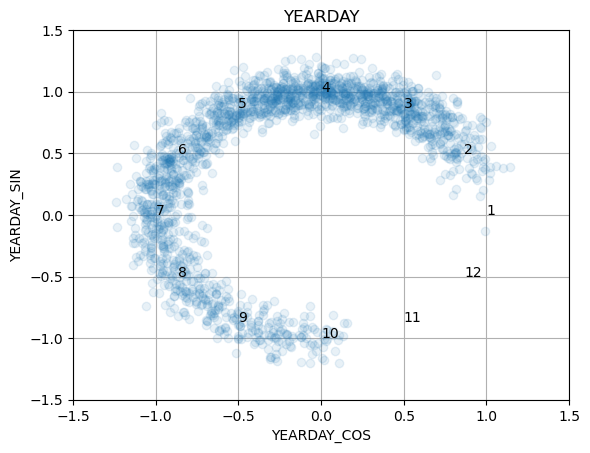

In [166]:
plt.clf()
plt.title("YEARDAY")
plt.xlabel("YEARDAY_COS")
plt.ylabel("YEARDAY_SIN")
plt.grid(True)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
e1 = 0.1*np.random.normal(size=dx.shape[0])
e2 = 0.1*np.random.normal(size=dx.shape[0])
plt.plot(dx["YEARDAY_COS"]+e1, dx["YEARDAY_SIN"]+e2, "o", alpha=0.1)
for i in range(12):
    x = np.cos(2*np.pi*i*30.5/366)
    y = np.sin(2*np.pi*i*30.5/366)
    plt.text(x, y, str(i+1))
plt.show()

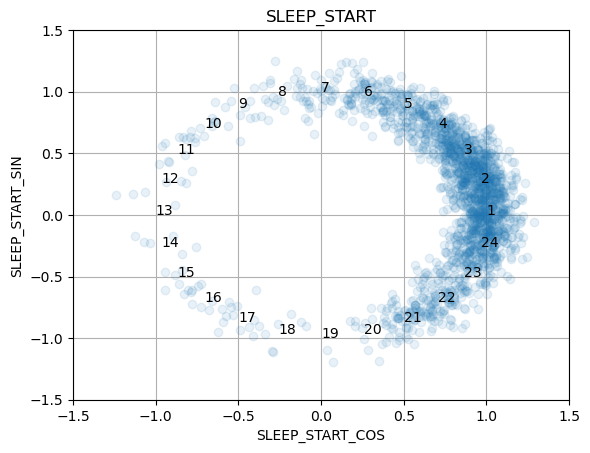

In [167]:
plt.clf()
plt.title("SLEEP_START")
plt.xlabel("SLEEP_START_COS")
plt.ylabel("SLEEP_START_SIN")
plt.grid(True)
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
e1 = 0.1*np.random.normal(size=dx.shape[0])
e2 = 0.1*np.random.normal(size=dx.shape[0])
plt.plot(dx["SLEEP_START_COS"]+e1, dx["SLEEP_START_SIN"]+e2, "o", alpha=0.1)
for i in range(24):
    x = np.cos(2*np.pi*i/24)
    y = np.sin(2*np.pi*i/24)
    plt.text(x, y, str(i+1))
plt.show()

Standardize the sleep variables.

In [168]:
exclude = ["STUDY_PRTCPT_ID", "STUDYDAY", "YEARDAY_SIN", "YEARDAY_COS", "YEARDAY", "DAYOFWEEK"]
va = [x for x in dx.columns if x not in exclude]
dx[va] = dx[va] - dx[va].mean(0)
dx[va] = dx[va] / dx[va].std(0)
dx["STUDY_PRTCPT_ID"].value_counts()

W7LX2I74    230
XKZF8SDS    189
T4CSRKVM    171
15LGWNGJ    152
XGJ8AFS8    142
RYFXBDFQ    112
CCD84K8N     81
MLYS5U85     76
N5F15GYZ     75
8MRVHIRR     74
UQUEK1XU     67
JEW6KQY3     52
KL8ZU5XC     49
VL61MMTY     48
SBTLFFUR     46
VZK8IVKE     41
3IJBZPI8     34
IS69SBYZ     29
1X8MBFBA     29
F1MALNM8     25
JU3R5P4M     23
RQ5P4ZR8     23
Y8PEMP7K     22
M5ENQMEA     12
YRTQ7TKL      5
D1C3M5J2      2
TQLY4RDR      1
Name: STUDY_PRTCPT_ID, dtype: int64

<Axes: >

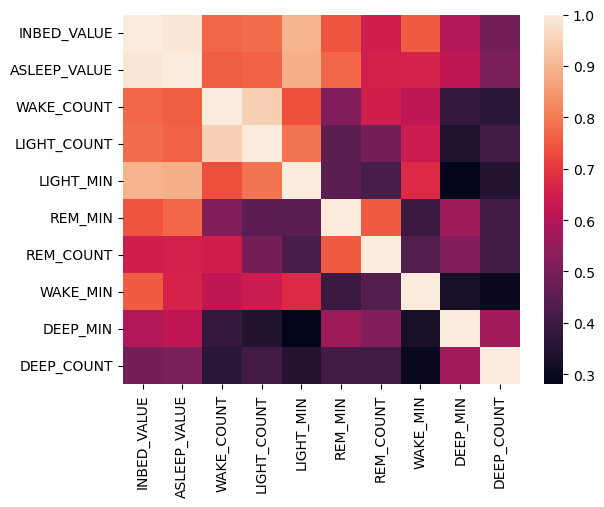

In [169]:
v = [x for x in va if not (x.endswith("_SIN") or x.endswith("_COS"))]
X = dx[v].copy()
X0 = X - X.mean(0)
C = X0.corr()
a, b = eigh(C)
ii = np.argmax(a)
jj = np.argsort(b[:, ii])
X0 = X0.iloc[:, jj]
sns.heatmap(X0.corr())

Plot histograms of each sleep variable.

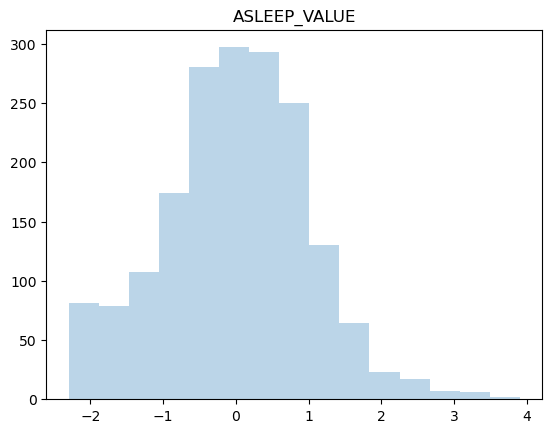

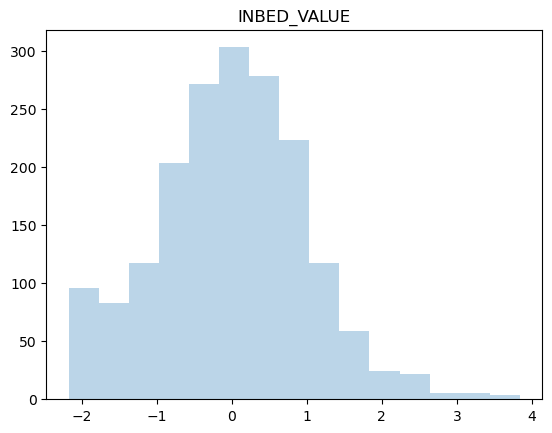

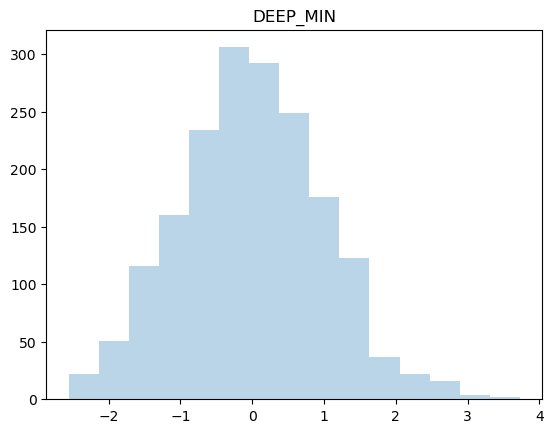

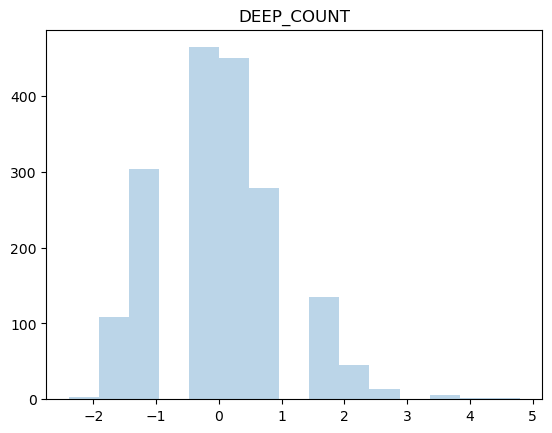

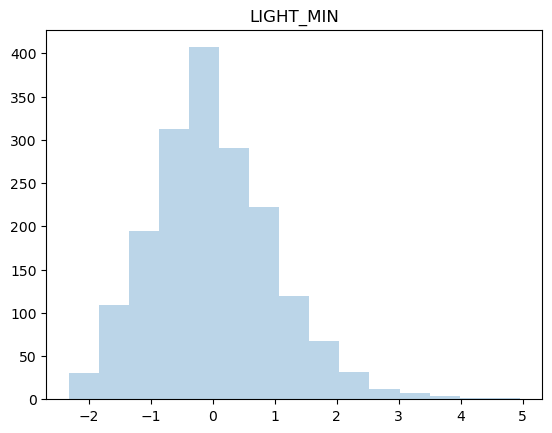

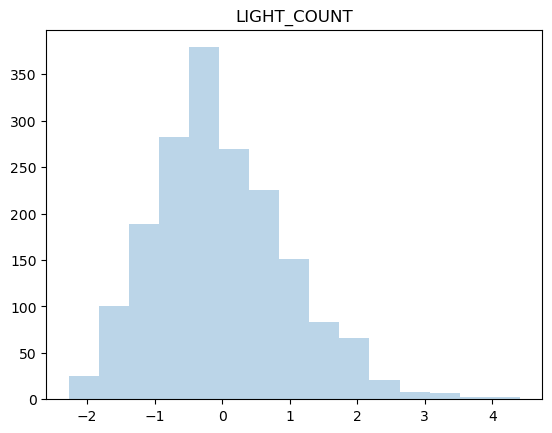

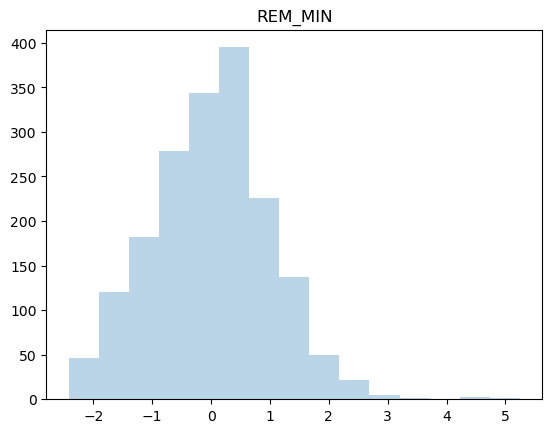

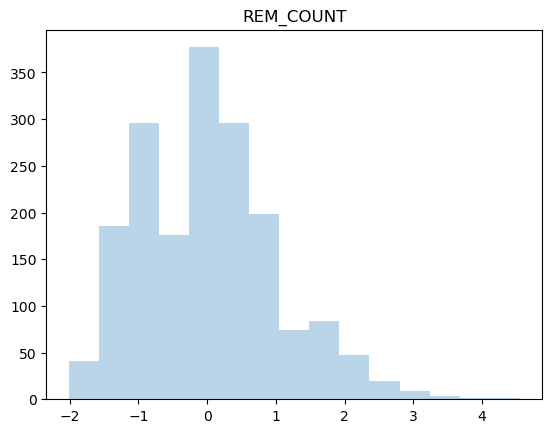

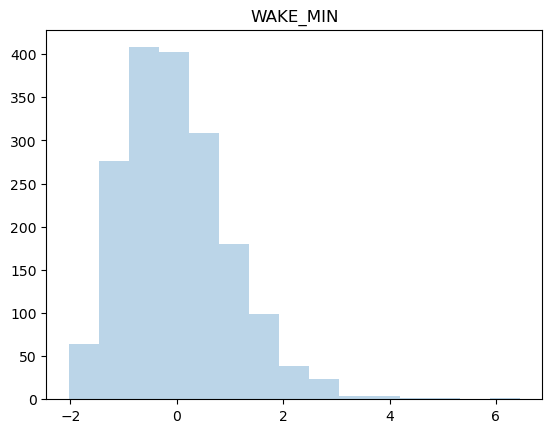

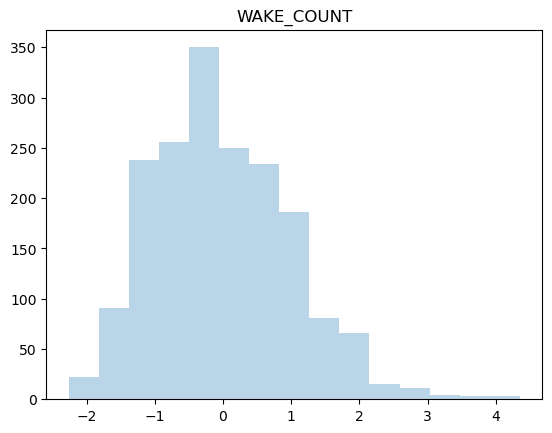

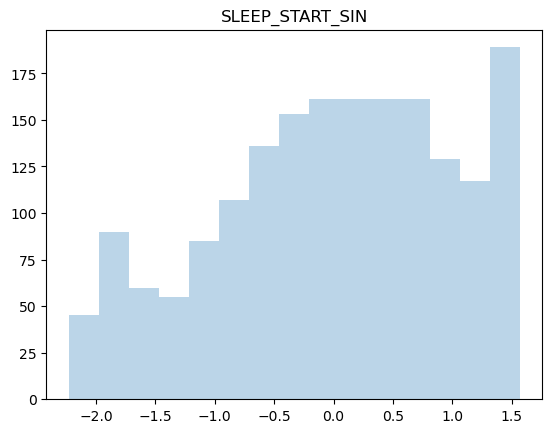

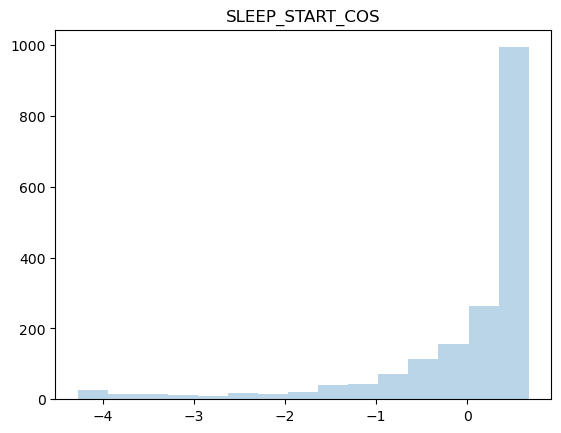

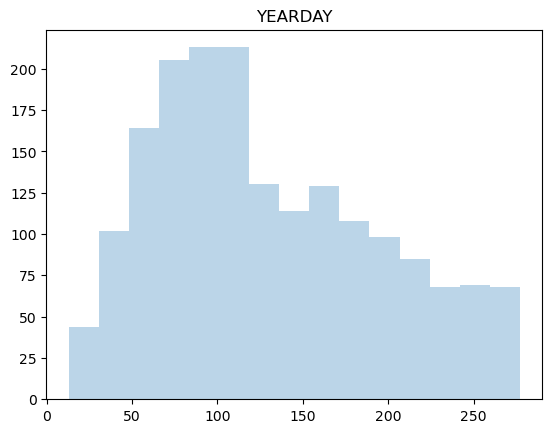

In [170]:
for v in va + ["YEARDAY"]:
    plt.hist(dx[v], bins=15, alpha=0.3)
    plt.title(v)
    plt.show()

# PCA/biplots

In [171]:
def plot_eigs(eigs):
    jj = np.arange(1, len(eigs) + 1)
    ii = np.flatnonzero(eigs >= 1e-10)
    plt.clf()
    plt.grid(True)
    plt.plot(np.log(jj[ii]), np.log(eigs[ii]), "-o")
    plt.ylabel("Log eigenvalue", size=15)
    plt.xlabel("Log position", size=15)
    plt.show()

In [172]:
def varimax(X, eps=1e-05, maxiter=1000):
    G = X.copy()
    m, p = G.shape
    Q = np.eye(p)
    if p < 2: 
        return G, Q
    d = 0.0
    for i in range(maxiter):
        z = np.dot(G, Q)
        cs = (z**2).sum(0)
        B = np.dot(G.T, z**3 - z * (cs / m))
        u, s, vt = np.linalg.svd(B, 0)
        Q = np.dot(u, vt)
        dlast = d
        d = s.sum()
        if d < dlast * (1 + eps): 
            break
            
    G = np.dot(G, Q)
    return G, Q

In [173]:
def ellipse_plot(U, idx, j0, j1):
    r2 = chi2(2).ppf(0.95)
    rr = np.sqrt(r2)
    dx = pd.DataFrame({"u0": U[:, 0], "u1": U[:, 1], "id": idx})
    plt.clf()
    plt.figure(figsize=(10, 10))
    plt.grid(True)
    plt.plot(dx["u0"], dx["u1"], "o", color="black", alpha=0.05)
    for (ky,dg) in dx.groupby("id"):
        if dg.shape[0] > 10:
            m0, m1 = dg["u0"].mean(), dg["u1"].mean()
            C = np.cov(dg["u0"], dg["u1"])
            a, b = eigh(C)
            plt.plot([m0], [m1], "o", color="blue", ms=8, alpha=0.2)
            ang = np.arctan2(b[1, 1], b[0, 1])*360/(2*np.pi)
            E = Ellipse(xy=[m0,m1], width=rr*np.sqrt(a[1]), height=rr*np.sqrt(a[0]), fc="none", ec="black", angle=ang)
            plt.gca().add_artist(E)
    plt.xlabel("Component %d" % j0, size=17)
    plt.ylabel("Component %d" % j1, size=17)
    plt.show()

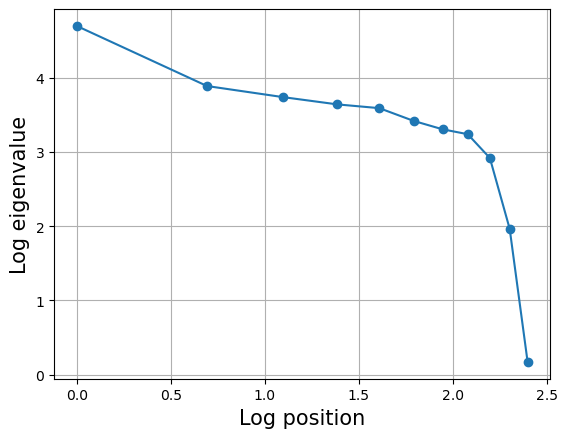

<Figure size 640x480 with 0 Axes>

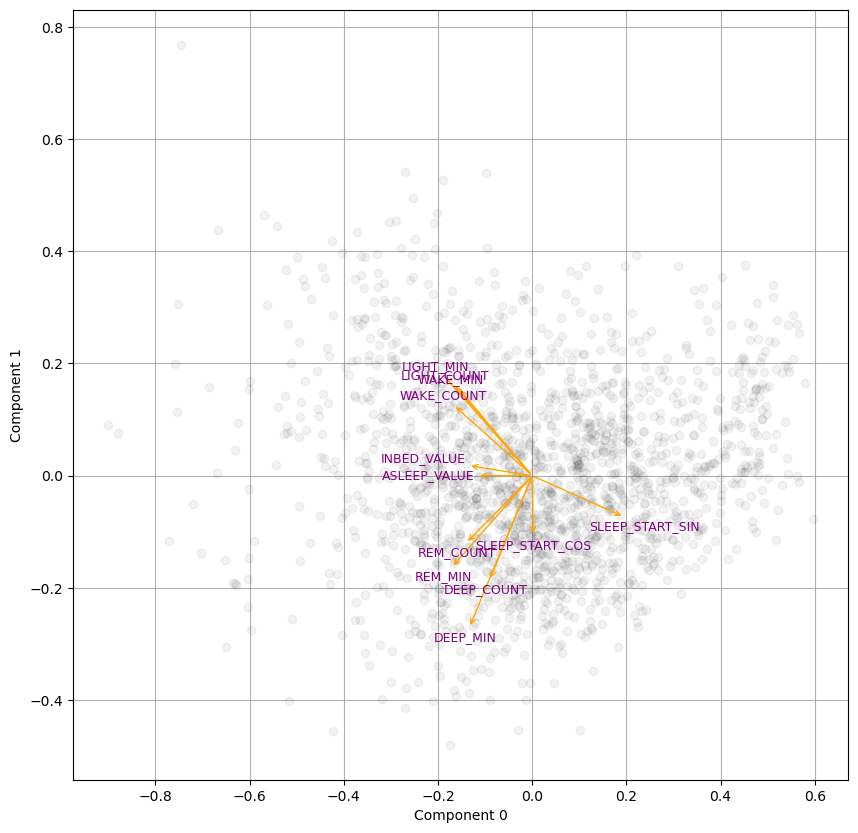

<Figure size 640x480 with 0 Axes>

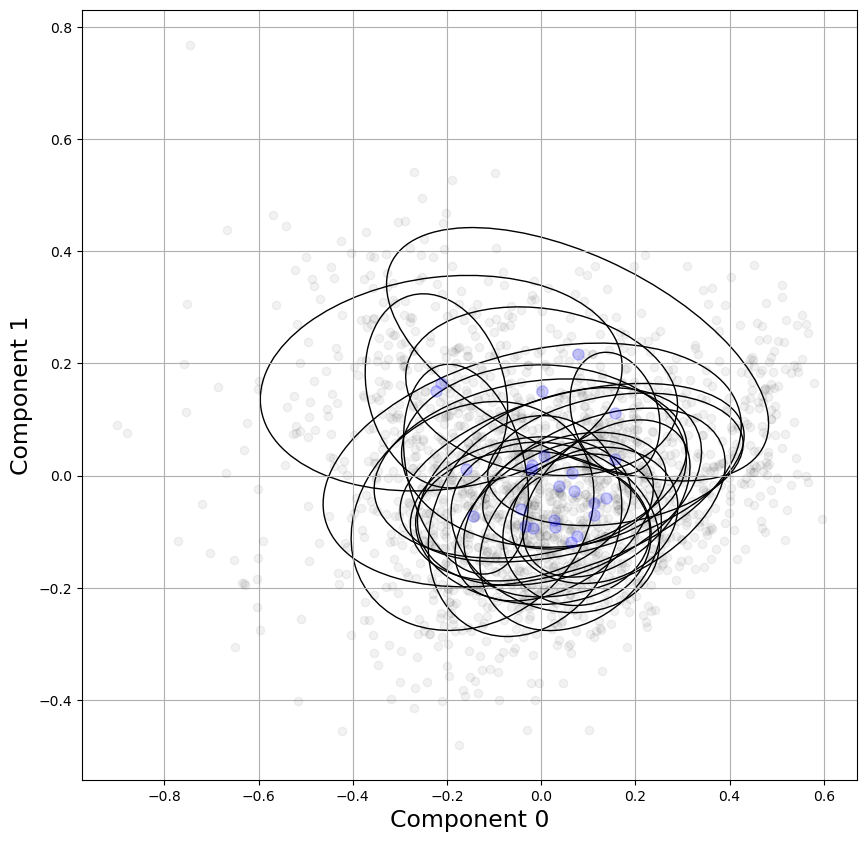

<Figure size 640x480 with 0 Axes>

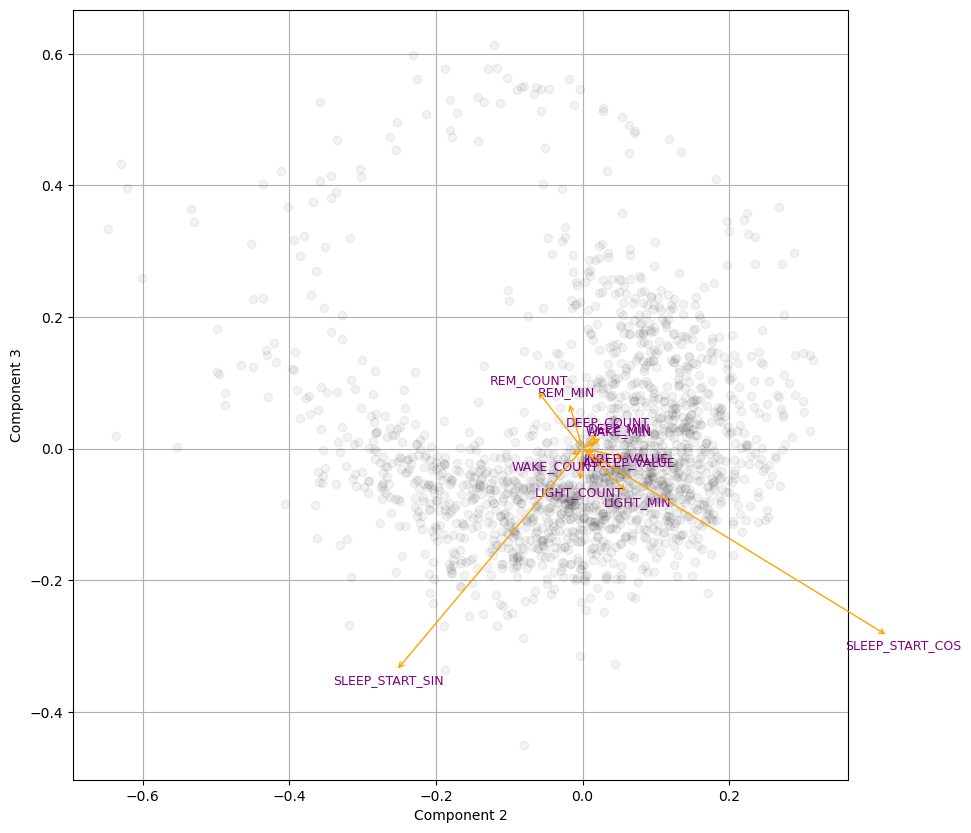

<Figure size 640x480 with 0 Axes>

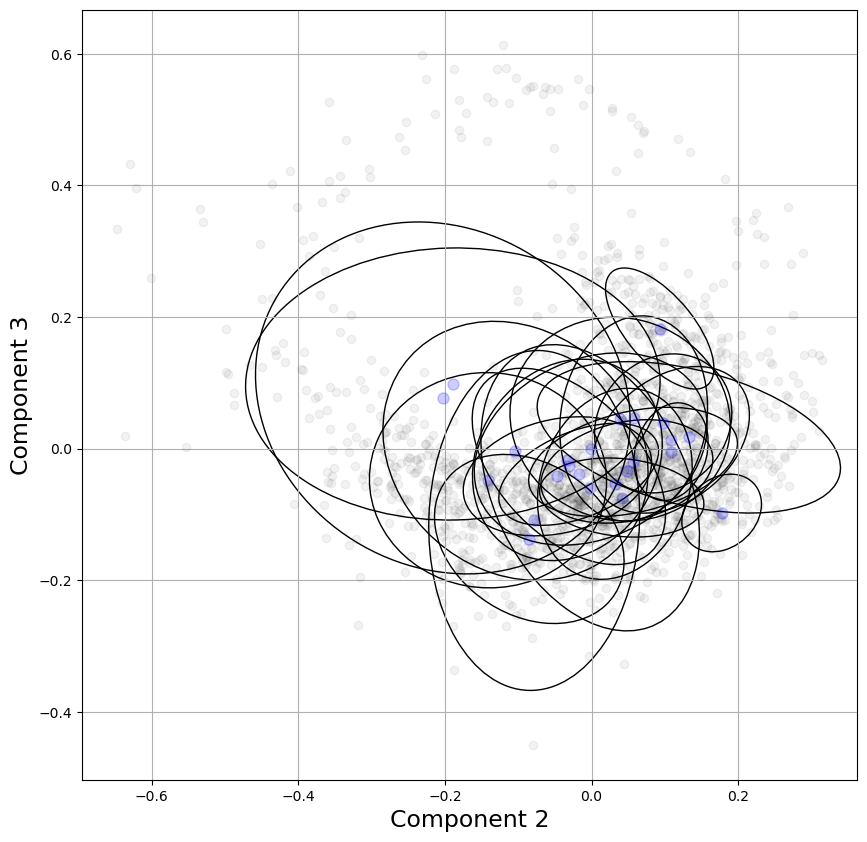

<Figure size 640x480 with 0 Axes>

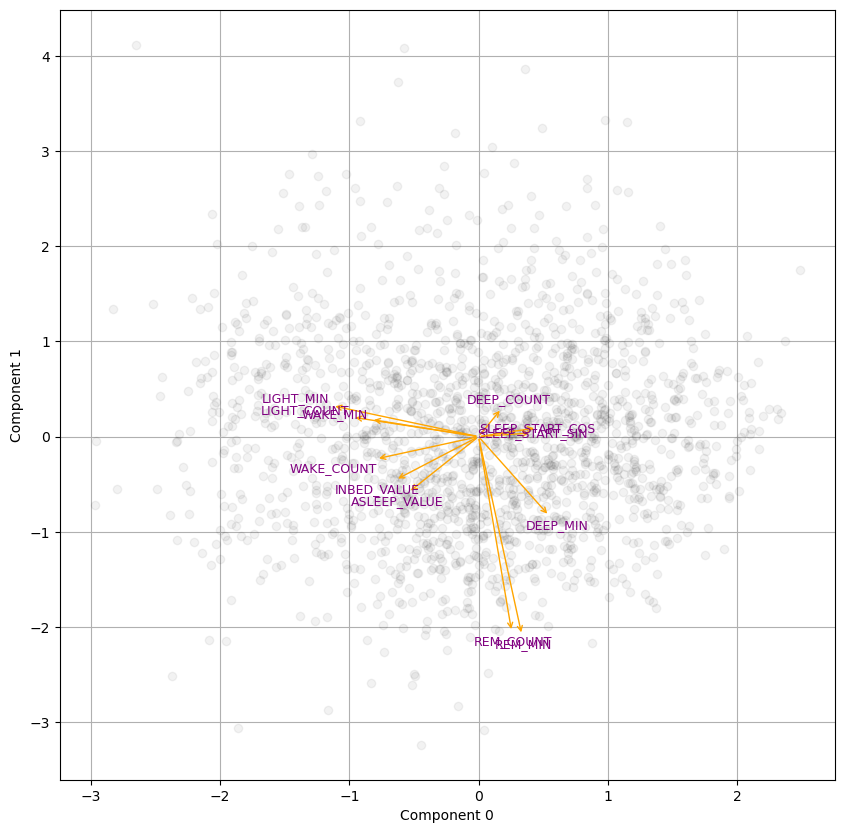

<Figure size 640x480 with 0 Axes>

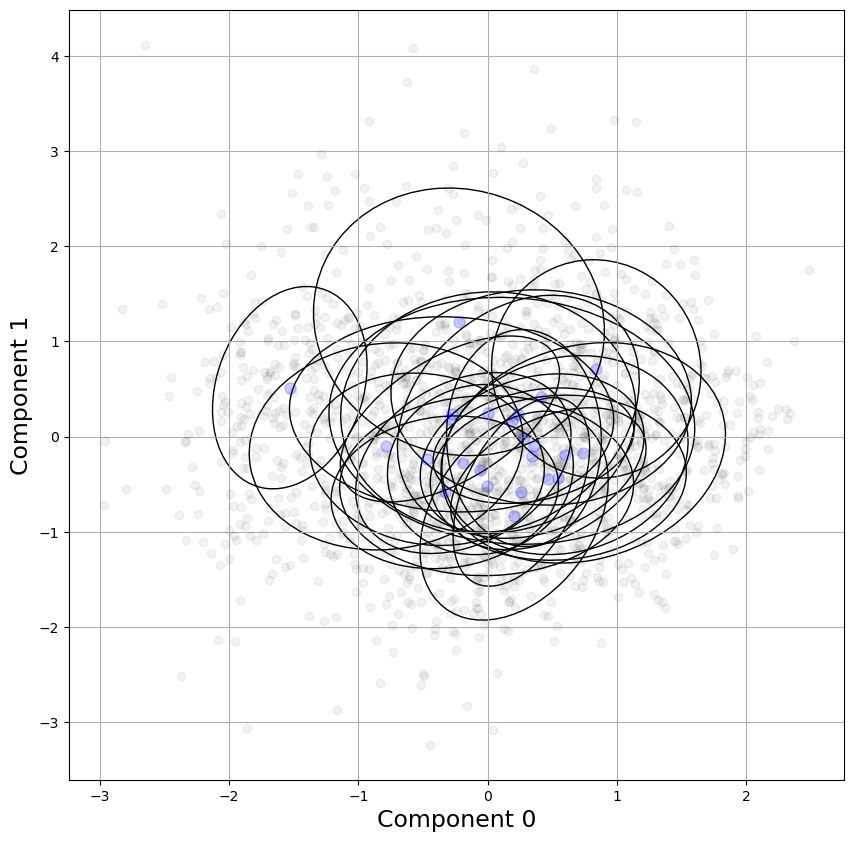

<Figure size 640x480 with 0 Axes>

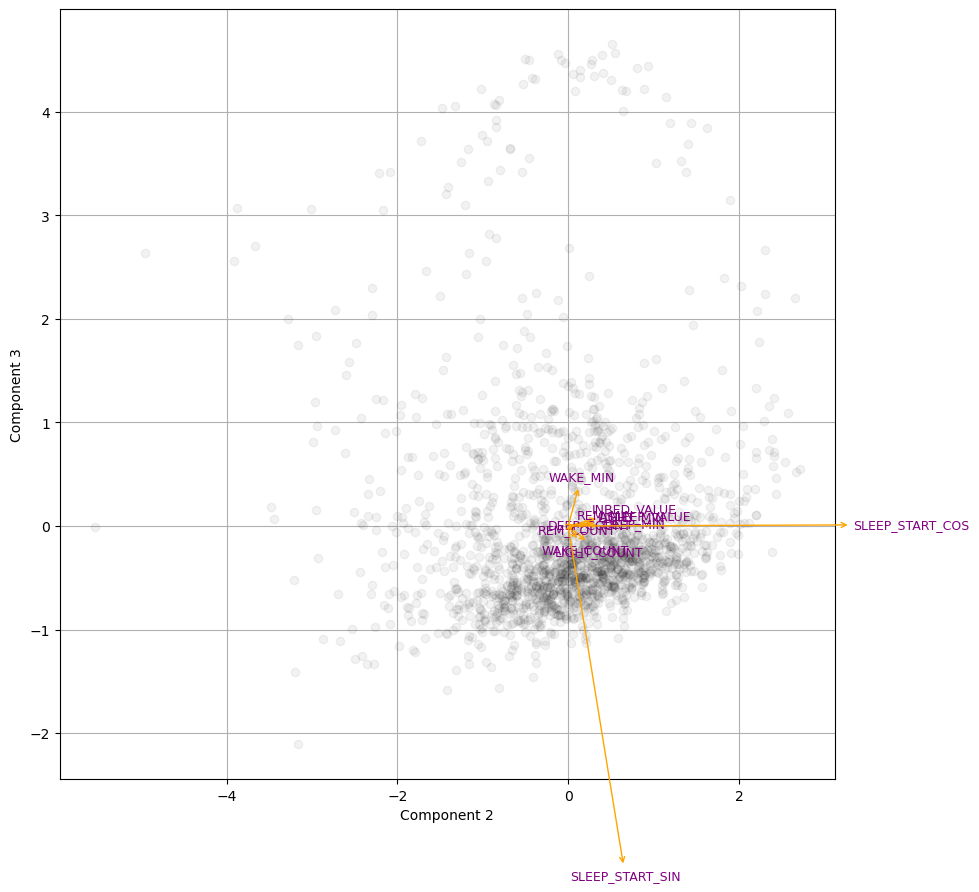

<Figure size 640x480 with 0 Axes>

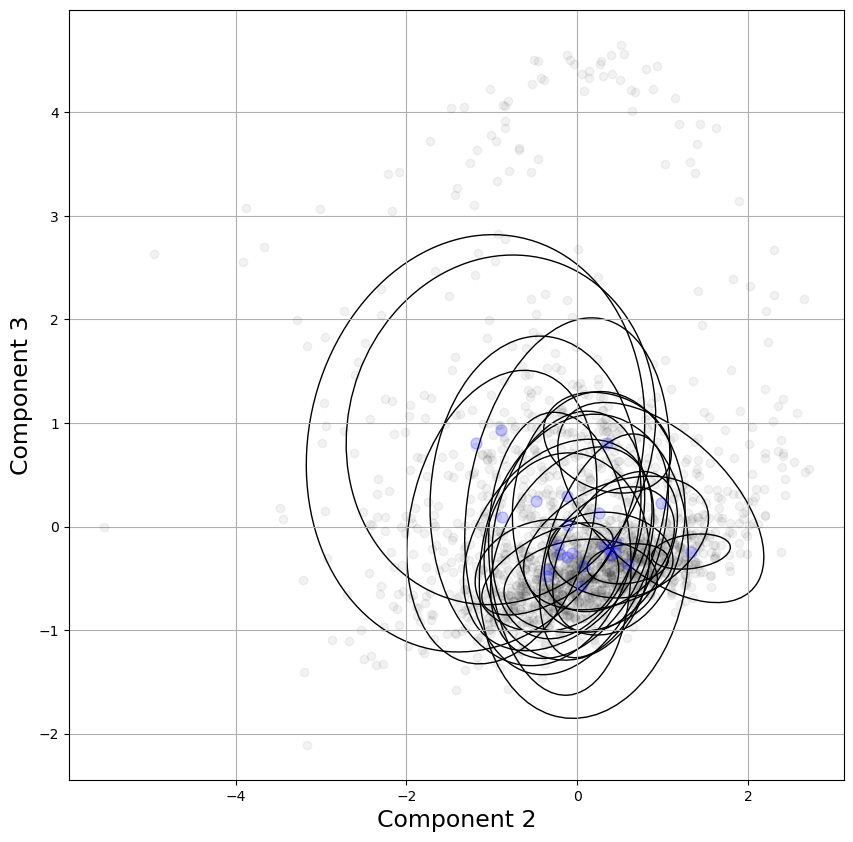

In [174]:
def biplot(dx, va, j=0, k=1, d=5, rotate=False, scree=False, ellipses=False):
    assert d > max(j, k)
    dx = dx.copy()
    X = np.asarray(dx[va])
    n, p = X.shape
    X -= X.mean()
    X -= X.mean(0)
    u, s, vt = np.linalg.svd(X, 0)
    v = vt.T
    if scree:
        plot_eigs(s)
    uu = u[:, 0:d]
    vv = v[:, 0:d]
    ss = s[0:d]
    if rotate:
        uu, Ru = varimax(uu)
        uu *= np.sqrt(n)
        vv, Rv = varimax(vv)
        vv *= np.sqrt(p)
        B = np.dot(Ru.T * ss, Rv) / np.sqrt(n*p)
    else:
        uu *= (ss**0.5)
        vv *= (ss**0.5)
        B = np.eye(d)
        
    ff = np.sqrt(X.shape[0] / X.shape[1]) # May need to adjust this
    v /= ff
    plt.clf()
    plt.figure(figsize=(10, 10))
    plt.grid(True)
    plt.plot(uu[:, j], uu[:, k], "o", color="black", alpha=0.05)
    for i in range(v.shape[0]):
        plt.annotate(va[i], xy=(0, 0), xytext=(vv[i, j], vv[i, k]), 
                     arrowprops=dict(color='orange', arrowstyle="<-"), color="purple", size=9)
    plt.xlabel("Component %d" % j)
    plt.ylabel("Component %d" % k)
    plt.show()
    
    if ellipses:
        ellipse_plot(uu[:, [j, k]], dx["STUDY_PRTCPT_ID"], j,k)
        
biplot(dx, va, 0, 1, d=5, rotate=False, scree=True, ellipses=True)
biplot(dx, va, 2, 3, d=5, rotate=False, ellipses=True)
biplot(dx, va, 0, 1, d=5, rotate=True, ellipses=True)
biplot(dx, va, 2, 3, d=5, rotate=True, ellipses=True)

# MANOVA

Use multivariate analysis of variance (MANOVA) to understand the between-subject and within-subject differences.

In [175]:
def manova1(dx, va, grp):
    """
    Run MANOVA on the data in dx[va], which have been centered.  The groups are
    defined by the column dx[grp].
    
    Returns:
    - H : Scaled estimate of Cov E[X|g]
    - E : Scaled estimate of E Cov[X|g]
    - ee : eigenvalues of E^-1 H
    - B : eigenvectors of E^-1 H
    - (pillai, trace, lawley, roy) : fit statistics
    """
    dg = dx.groupby(grp)[va]
    X = dx[va].values
    w = dg.size()
    M = dg.mean()
    assert all(w.index == M.index)
    w = w.values
    M = M.values
    Mw = np.sqrt(w)[:, None] * M
    H = np.dot(Mw.T, Mw)
    E = np.dot(X.T, X) - H
    ee, B = eigh(H, E)
    if ee.min() < 0:
        raise ValueError("Negative eigenvalue in MANOVA")
    ii = np.argsort(-ee)
    ee = ee[ii]
    B = B[:, ii]
    pillai = np.sum(ee / (1 + ee))
    lawley = np.sum(ee)
    wilks = np.prod(1 / (1 + ee))
    roy = ee[0] / (1 + ee[0])
    return H, E, ee, B, (pillai, lawley, wilks, roy)

In [176]:
def manova(dx, va, grp, nrep=1000, center=True):
    """
    Run MANOVA on the data in X, using randomization to calibrate the statistics.
    
    Returns:
    - H : Scaled estimate of Cov E[X|g]
    - E : Scaled estimate of E Cov[X|g]
    - ee : eigenvalues of E^-1 H
    - B : eigenvectors of E^-1 H
    - (pillai, trace, lawley, roy) : fit statistics
    - stats0 : each row is a randomized realization of the fit statistics
    """
    dx = dx.copy()
    if center:
        dx[va] = dx[va] - dx[va].mean(0)
    X = dx[va].values
    a, _ = np.linalg.eigh(np.cov(X.T))
    if a.min() <= 1e-8:
        raise ValueError("The marginal covariance matrix is singular")
    n = dx.shape[0]
    H, E, ee, B, stats = manova1(dx, va, grp)
    stats0 = np.empty((nrep, 4))
    for i in range(nrep):
        dx[grp] = dx[grp].sample(frac=1).values
        _, _, _, _, s = manova1(dx, va, grp)
        stats0[i, :] = s
        
    return X, H, E, ee, B, stats, stats0

Transform the MANOVA summary statistics to make them more interpretable.

In [177]:
def xstat_manova(stats, stats0, p):
    stats = np.copy(stats)
    stats0 = np.copy(stats0)
    # Pillai becomes the mean PVE
    stats[0] /= p
    stats0[:, 0] /= p
    # Lawley becomes the mean SNR
    stats[1] /= p
    stats0[:, 1] /= p
    # Wilks becomes the geometric mean of 1 - PVE
    stats[2] = np.power(stats[2], 1/p)
    stats0[:, 2] = np.power(stats0[:, 2], 1/p)
    # Not sure what to do with this...
    stats[3] = np.power(stats[3], 1/p)
    stats0[:, 3] = np.power(stats0[:, 3], 1/p)
    return stats, stats0

Run the MANOVA to assess inter-subject differences.  ASLEEP_VALUE is redundant so drop it here.

In [178]:
va1 = [x for x in va if x != "ASLEEP_VALUE"]
X0, H, E, ee, B, stats, stats0 = manova(dx, va1, "STUDY_PRTCPT_ID")
statsx, stats0x = xstat_manova(stats, stats0, len(va))

Plot the summary statistics.

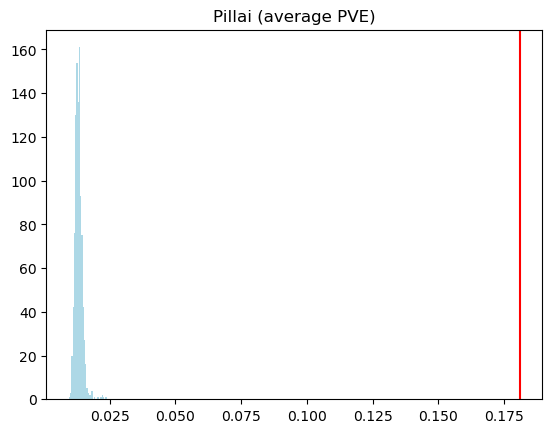

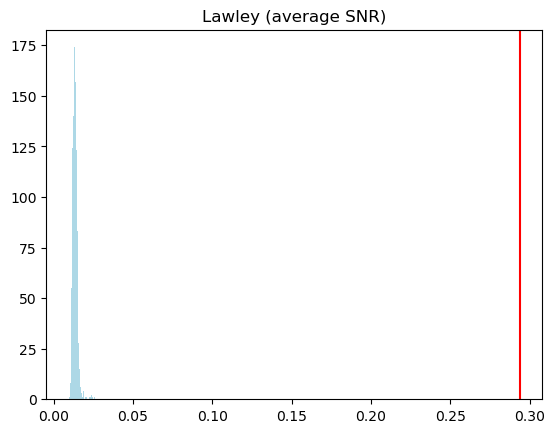

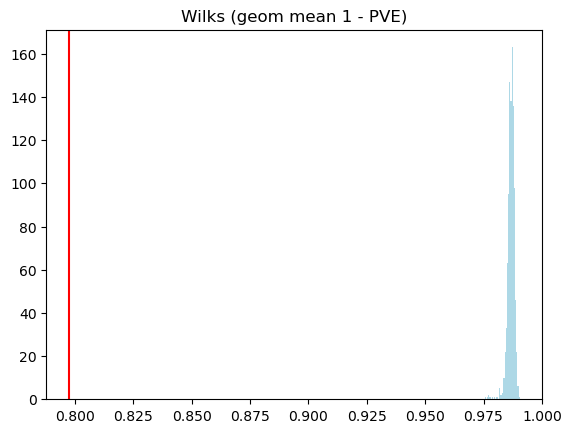

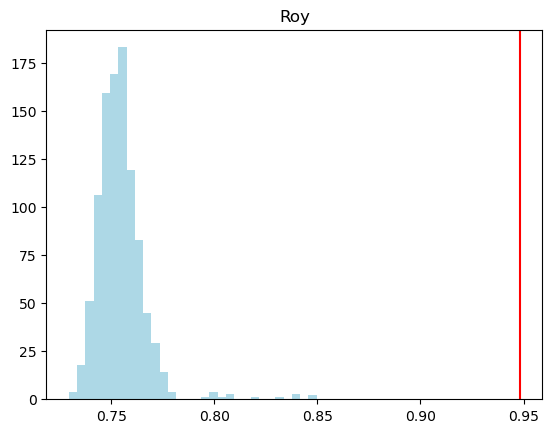

In [179]:
for (k, ti) in enumerate(["Pillai (average PVE)", "Lawley (average SNR)", "Wilks (geom mean 1 - PVE)", "Roy"]):
    plt.hist(stats0x[:, k], bins=30, color="lightblue")
    plt.axvline(statsx[k], color="red")
    plt.title(ti)
    plt.show()

Generate biplots to show how the MANOVA factors relate to the observed variables

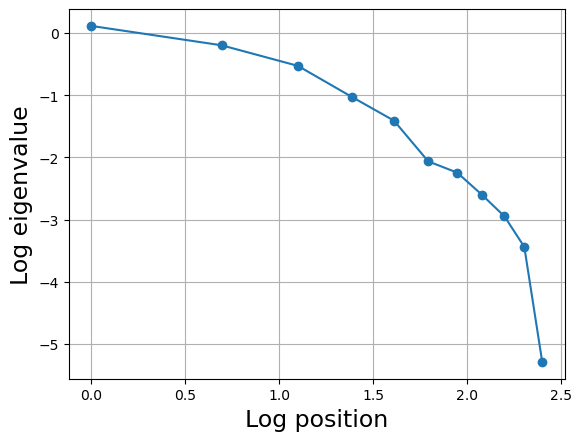

<Figure size 640x480 with 0 Axes>

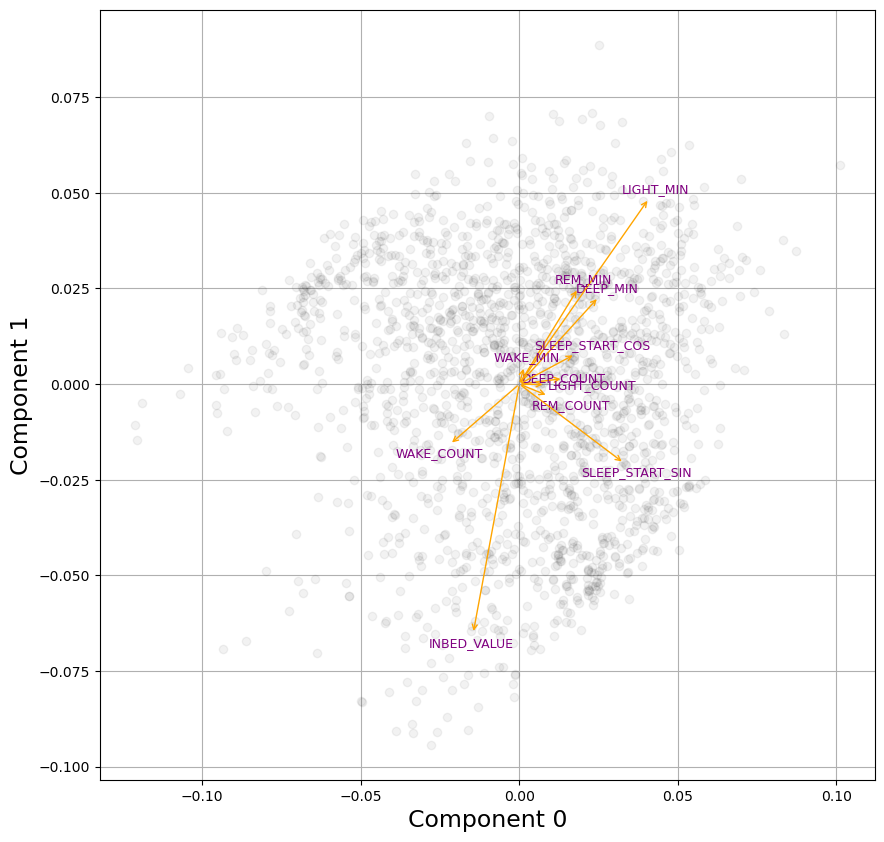

<Figure size 640x480 with 0 Axes>

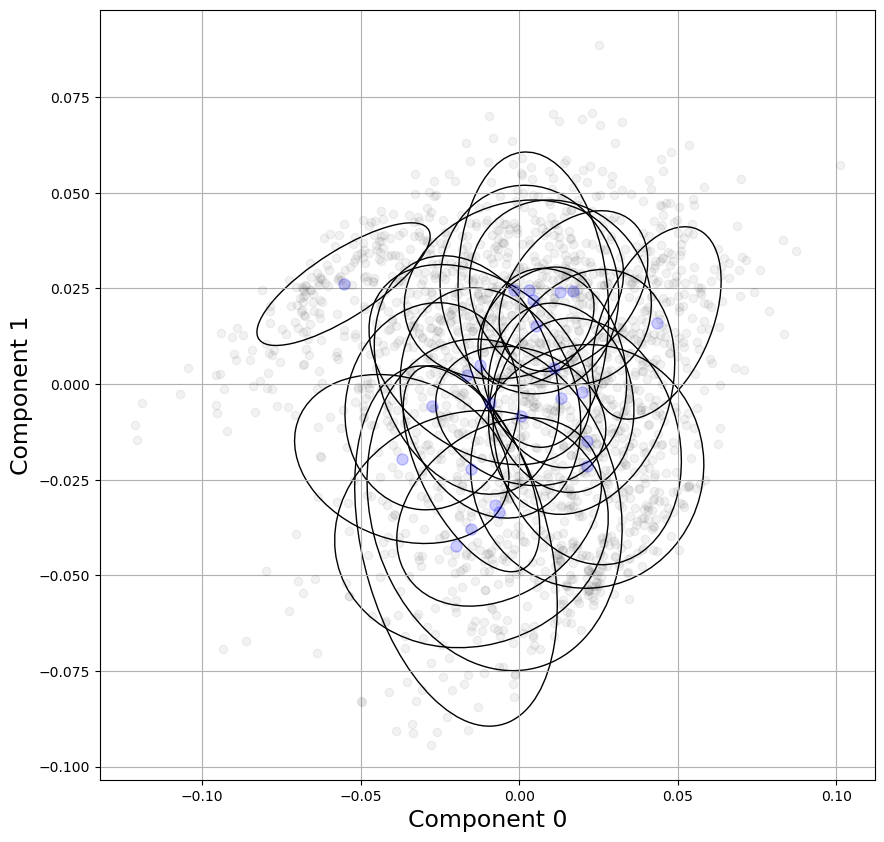

<Figure size 640x480 with 0 Axes>

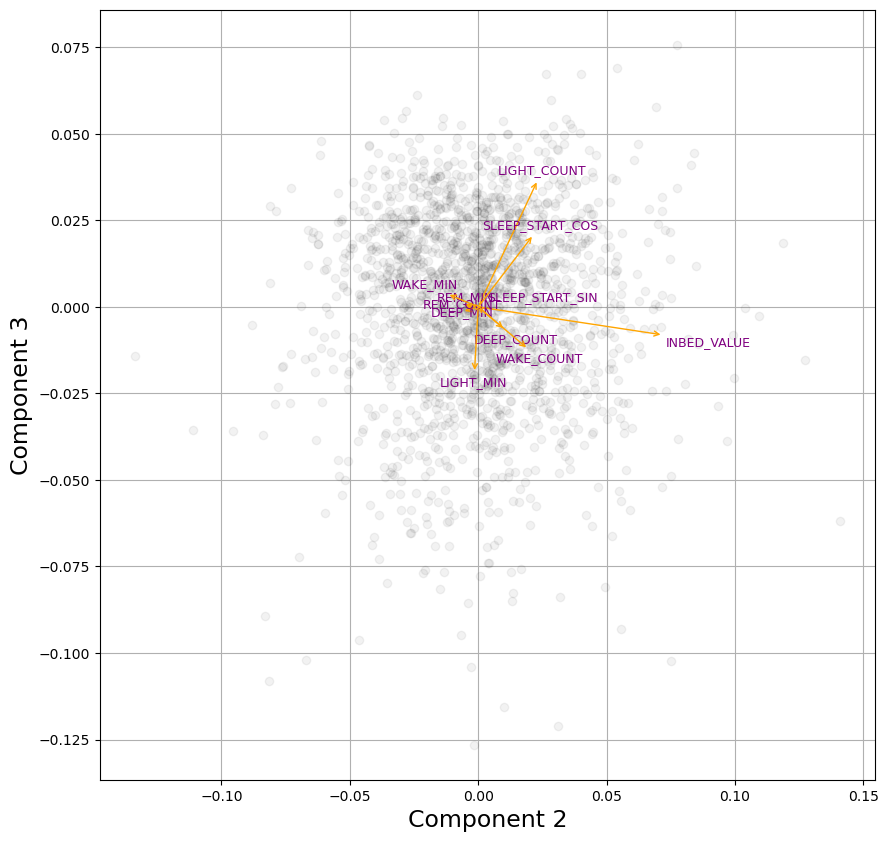

<Figure size 640x480 with 0 Axes>

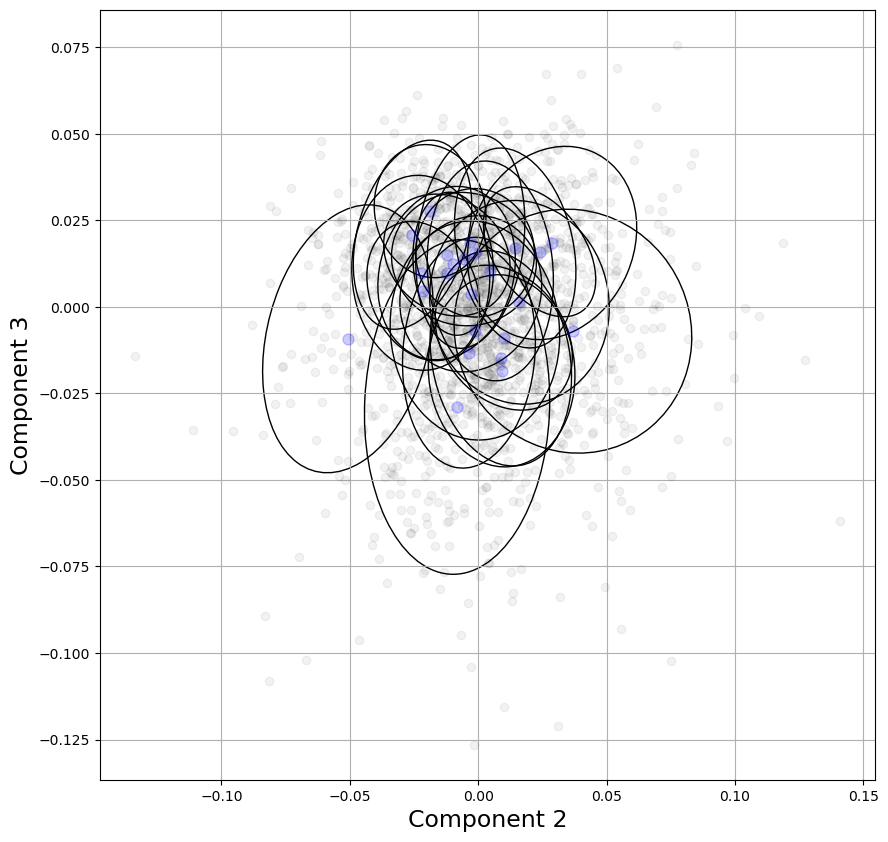

<Figure size 640x480 with 0 Axes>

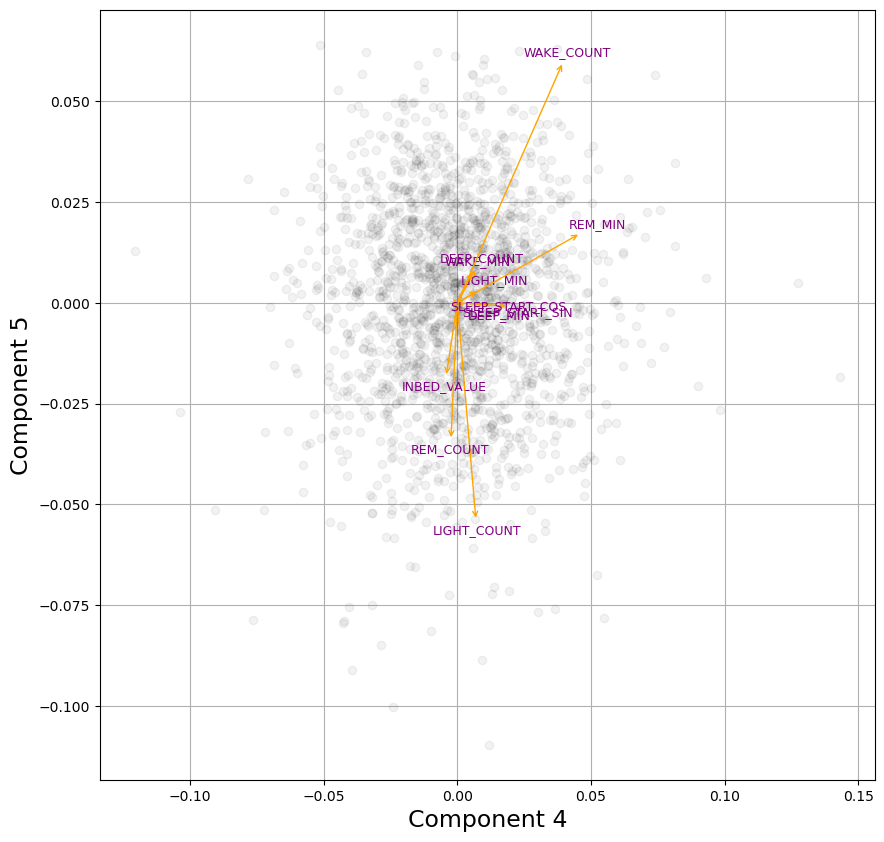

<Figure size 640x480 with 0 Axes>

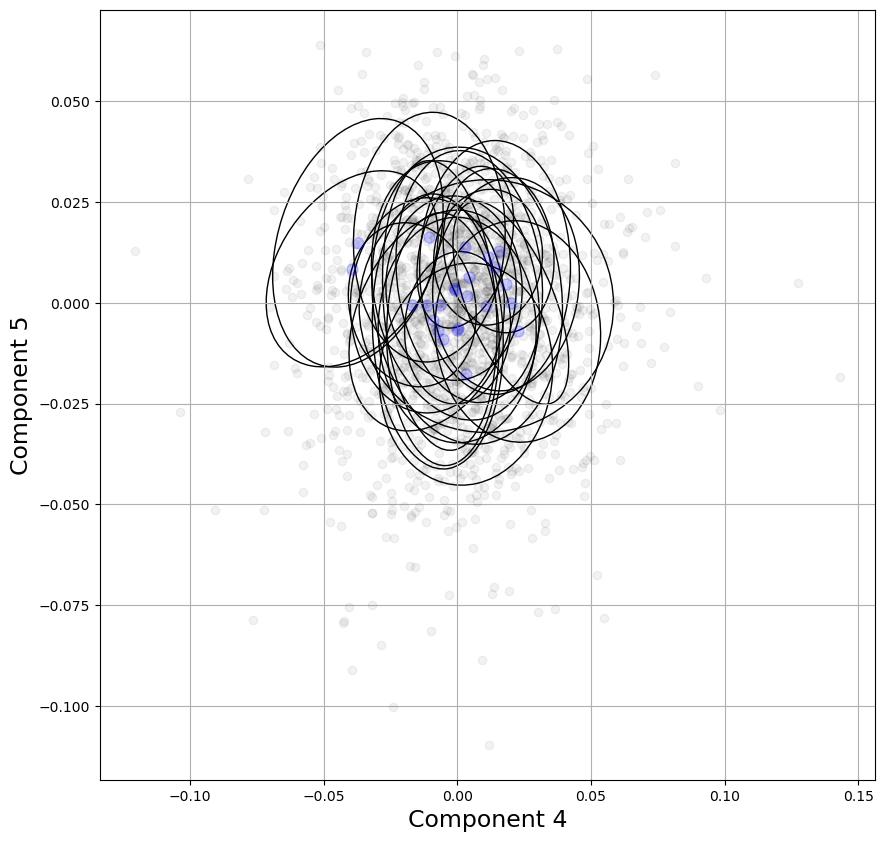

In [180]:
def biplot(j0, j1, X0, B, ee, va, scree=False, ellipses=True):
    scores = np.dot(X0, B[:, [j0, j1]])
    if scree:
        plt.clf()
        plt.grid(True)
        jj = np.arange(1, len(ee)+1)
        plt.plot(np.log(jj), np.log(ee), "-o")
        plt.xlabel("Log position", size=17)
        plt.ylabel("Log eigenvalue", size=17)
        plt.show()
    plt.clf()
    plt.figure(figsize=(10,10))
    plt.grid(True)
    plt.plot(scores[:, 0], scores[:, 1], "o", color="black", alpha=0.05)
    for i in range(B.shape[0]):
        plt.annotate(va[i], xy=(0, 0), xytext=(B[i, j0], B[i, j1]), 
                     arrowprops=dict(color='orange', arrowstyle="<-"), color="purple", size=9)
    plt.xlabel("Component %d" % j0, size=17)
    plt.ylabel("Component %d" % j1, size=17)
    plt.show()

    if ellipses:
        ellipse_plot(scores, dx["STUDY_PRTCPT_ID"], j0, j1)
    
biplot(0, 1, X0, B, ee, va1, scree=True, ellipses=True)
biplot(2, 3, X0, B, ee, va1, ellipses=True)
biplot(4, 5, X0, B, ee, va1, ellipses=True)

# Dimension reduction regression

Use sliced inverse regression to understand the possible roles of day of week, and seasonality

In [181]:
def sir(dx, xv, yv):
    dx = dx.copy()
    dx[xv] = dx[xv] - dx[xv].mean(0)
    C = dx[xv].cov()
    a,_ = eigh(C)
    if a.min() < 1e-10:
        raise ValueError("Marginal covariance of predictors is singular")
    mn, wt = [], []
    for (ky,dg) in dx.groupby(yv):
        mn.append(dg[xv].mean(0))
        wt.append(dg.shape[0])
    M = np.stack(mn)
    wt = np.asarray(wt)
    wt = wt / wt.sum()
    Mw = np.sqrt(wt)[:, None] * M
    H = np.dot(Mw.T, Mw)    
    a, b = eigh(H, C)
    ii = np.argsort(-a)
    a = a[ii]
    b = b[:, ii]
    b = pd.DataFrame(b, columns=["B%d" % j for j in range(len(xv))], index=xv)
    return b, a

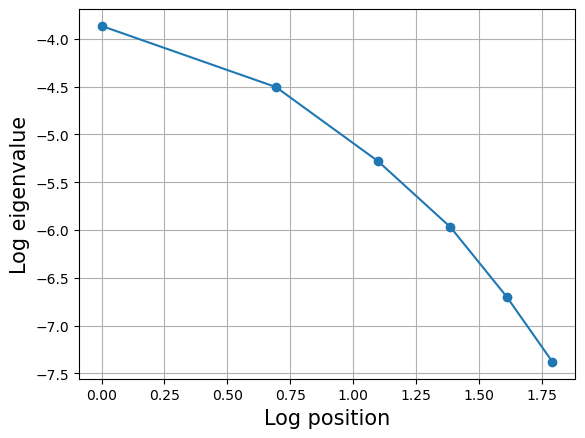

B0        B1        B2        B3
DEEP_MIN        -0.269828  0.329036  0.148771 -0.851618
DEEP_COUNT      -0.039467  0.065625 -0.665867  0.519352
LIGHT_MIN       -0.794248 -0.552368  0.185711 -0.911046
LIGHT_COUNT      0.315917  1.672467  0.202504  0.941060
REM_MIN         -0.243473 -0.267806  0.414356  0.518458
REM_COUNT       -0.242282  0.168493 -0.377468  0.515324
WAKE_MIN         0.106245  0.294386 -0.224968 -0.209726
WAKE_COUNT       0.139769 -1.543406  0.653347 -0.294179
SLEEP_START_SIN -0.789457  0.276227 -0.148133 -0.045698
SLEEP_START_COS  0.280264  0.724158  0.235147  0.123856

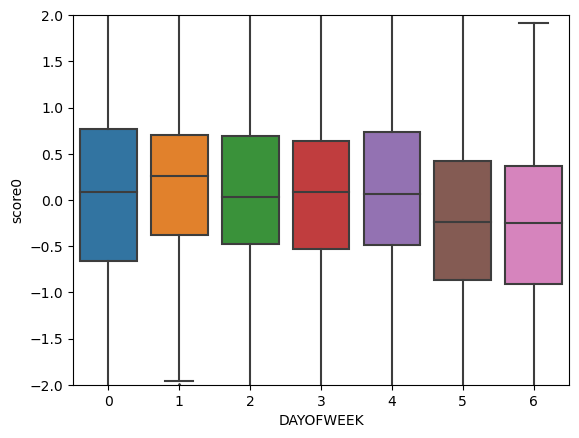

In [182]:
va2 = [x for x in va1 if x != "INBED_VALUE"]

dirs, eigs = sir(dx, va2, "DAYOFWEEK")
plot_eigs(eigs)

dirs.iloc[:, 0:4]
scores = np.dot(dx[va2], dirs.iloc[:, 0:3])

dp = pd.DataFrame({"DAYOFWEEK": dx["DAYOFWEEK"], "score0": scores[:, 0]})
sns.boxplot(dp, x="DAYOFWEEK", y="score0")
plt.ylim(-2, 2)
dirs.iloc[:, 0:4]

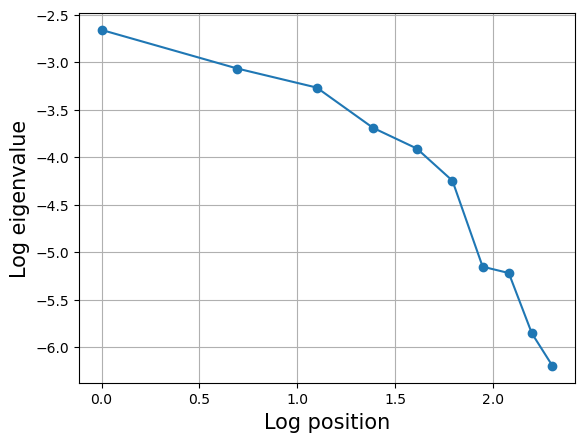

B0        B1        B2        B3
DEEP_MIN         0.084167  0.161764  0.045112  0.596982
DEEP_COUNT      -0.154772 -0.188886 -0.004901 -0.493160
LIGHT_MIN       -0.751683 -0.623642 -0.299493  0.983167
LIGHT_COUNT      0.995185  1.122676  0.641698 -1.638108
REM_MIN         -0.659126 -0.278777  0.208813 -0.458329
REM_COUNT        0.753576  1.177803  0.197125  0.218326
WAKE_MIN         0.322364 -0.023619  0.882444 -0.262782
WAKE_COUNT      -0.905359 -1.495596 -0.879928  0.662660
SLEEP_START_SIN  0.591800 -0.545227 -0.143610 -0.197652
SLEEP_START_COS -0.034474  0.336437 -0.684882 -0.450425

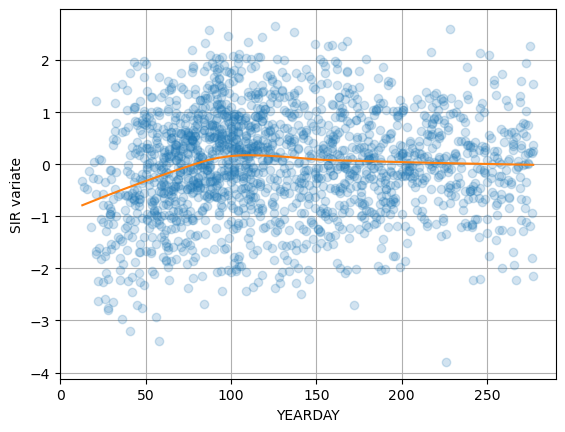

In [183]:
dx["YEARDAYu"] = pd.qcut(dx["YEARDAY"], 20)

dirs, eigs = sir(dx, va2, "YEARDAYu")
plot_eigs(eigs)

scores = np.dot(dx[va2], dirs.iloc[:, 0:3])

xy = lowess(scores[:, 0], dx["YEARDAY"])

plt.clf()
plt.grid(True)
plt.plot(dx["YEARDAY"], scores[:, 0], "o", alpha=0.2)
plt.plot(xy[:, 0], xy[:, 1], "-")
plt.ylabel("SIR variate")
plt.xlabel("YEARDAY")
dirs.iloc[:, 0:4]

# UMAP

This is a very popular modern method but I'm not sure whether it will be useful for us.  It is worth a try.

In [184]:
import umap

um = umap.UMAP(random_state=123)
emb = um.fit_transform(dx[va1])
emb -= emb.mean(0)
emb /= emb.std(0)

/home/kshedden/.local/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


Color the points by person

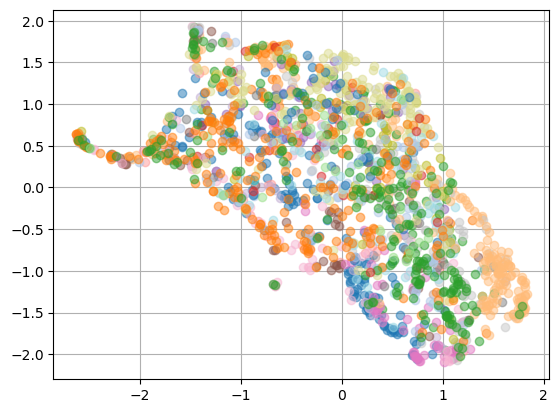

In [185]:
tab20 = matplotlib.colormaps["tab20"].colors
plt.clf()
plt.grid(True)
dp = pd.DataFrame({"id": dx["STUDY_PRTCPT_ID"], "emb0": emb[:, 0], "emb1": emb[:, 1]})
for j,(ky,dg) in enumerate(dp.groupby("id")):
    plt.plot(dg["emb0"], dg["emb1"], "o", alpha=0.5, color=tab20[j % 20])

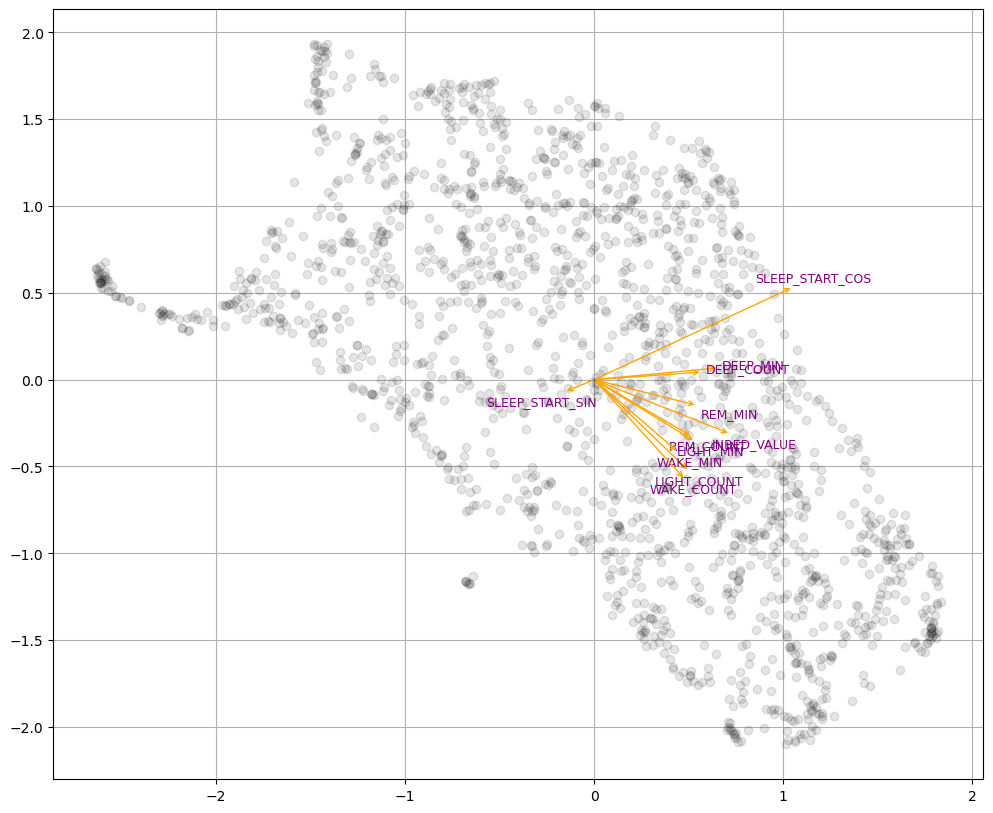

In [186]:
plt.clf
plt.figure(figsize=(12, 10))
plt.grid(True)
plt.plot(emb[:, 0], emb[:, 1], "o", color="black", alpha=0.1)
for v in va1:
    cc = np.linalg.lstsq(emb, dx[v], rcond=None)[0]
    plt.annotate(v, xy=(0, 0), xytext=cc, 
                 arrowprops=dict(color='orange', arrowstyle="<-"), color="purple", size=9)
plt.show()

<Figure size 640x480 with 0 Axes>

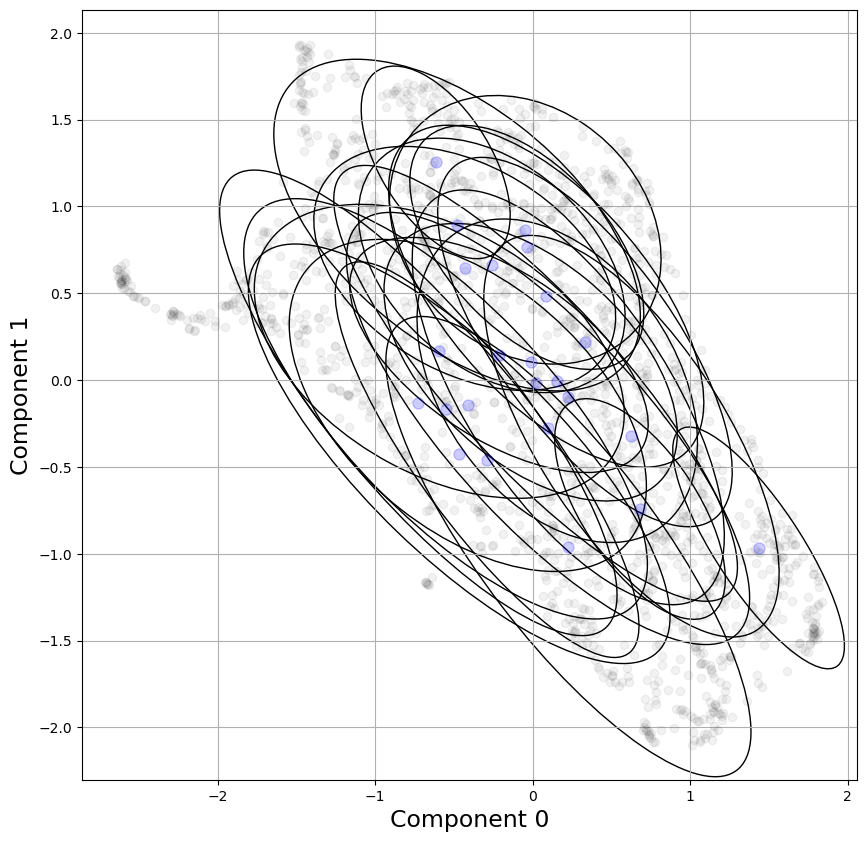

In [187]:
ellipse_plot(emb, dx["STUDY_PRTCPT_ID"], 0, 1)

# CORE

Covariance reduction to identify heteroscedasticity.

In [188]:
tab20 = matplotlib.colormaps["tab20"].colors

In [189]:
nobs = dx["STUDY_PRTCPT_ID"].value_counts()
nobs = pd.DataFrame({"STUDY_PRTCPT_ID": nobs.index, "nobs": nobs.values})
dy = pd.merge(dx, nobs, left_on="STUDY_PRTCPT_ID", right_on="STUDY_PRTCPT_ID")
dy = dy.loc[dy.nobs > 10, :]
idx = np.asarray(dy["STUDY_PRTCPT_ID"].astype(str))
X = np.asarray(dy[va2])
m = CORE(idx, X, 2)
r = m.fit(maxiter=1000)
qq = pd.DataFrame(r.params, va2, columns=["B%d" % j for j in range(2)])
qq

B0        B1
DEEP_MIN         0.001788 -0.024593
DEEP_COUNT       0.021250  0.006919
LIGHT_MIN       -0.002374 -0.076450
LIGHT_COUNT     -0.015359 -0.029553
REM_MIN          0.017326  0.006014
REM_COUNT       -0.036831 -0.069285
WAKE_MIN         0.004335 -0.010497
WAKE_COUNT       0.005895  0.017101
SLEEP_START_SIN  0.175123 -0.978882
SLEEP_START_COS -0.983324 -0.170824

<Figure size 640x480 with 0 Axes>

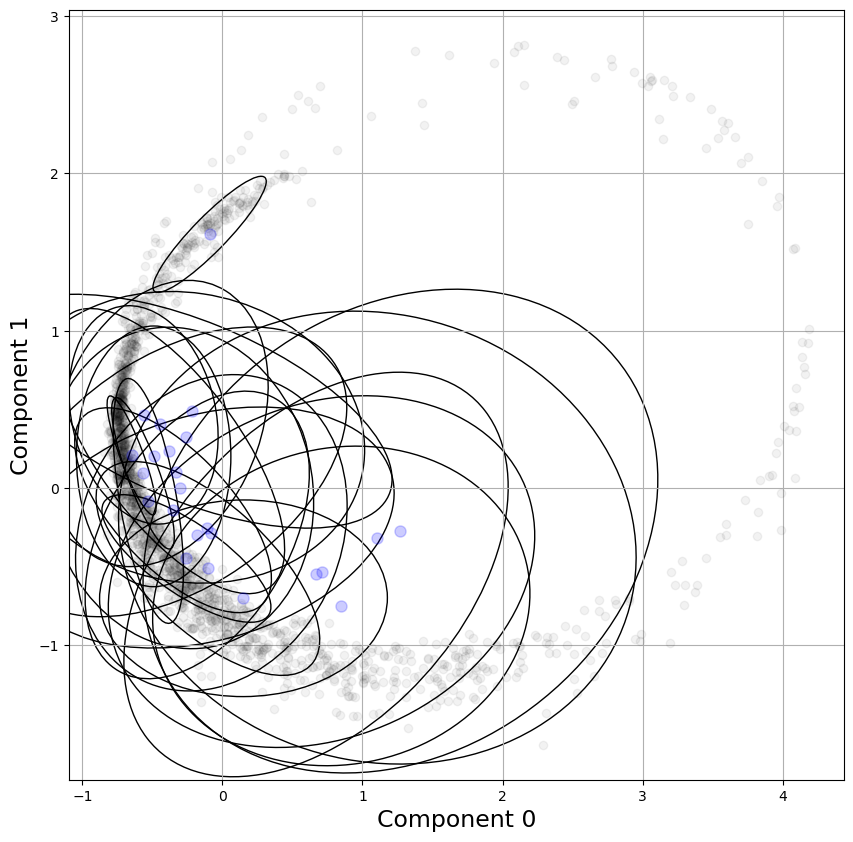

In [190]:
ellipse_plot(np.dot(X, r.params), dy["STUDY_PRTCPT_ID"], 0, 1)